# The 2D Ising Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
from matplotlib import colors as mcolors          # Packages to define custom colormaps
from matplotlib.animation import FuncAnimation    # and animations
plt.rcParams['font.family'] = 'serif'             #Change font to Times New Roman
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from numba import njit                            
from tqdm import tqdm                             # Allows you to see a "progress bar" to know how far a loop has progressed
import getpass
from scipy.optimize import curve_fit

### I have also made some changes to last assignment's code and as a result I am getting slightly different results (which make more sense), i realised what was going wrong after attending the DS on Ising Model and doing the assignment. 

In [2]:
@njit
def oneMCS(energy, beta, h, spins, J=1):
    """
    Performs one Monte Carlo step (MCS) in a physical system using the Metropolis algorithm.

    Parameters:
    -----------
    energy : float
        The current energy of the system.
    beta : float
        Inverse temperature parameter.
    h : float
        External magnetic field.
    spins : numpy.ndarray
        2D array representing the spins in the system.
    J : float
        Interaction strength, defaults to 1.

    Returns:
    --------
    energy : float
        Updated energy of the system after one Monte Carlo step.
    spins : numpy.ndarray
        Updated spin configuration after one Monte Carlo step.
    """
    L = L = len(spins) #np.shape(spins)[0]                 # Linear dimension of our square lattice
    N = L**2                               # Number of spins
    
    # Looping over N spins
    for _ in range(N):
        # Choose a random spin
        x = np.random.randint(0, L)
        y = np.random.randint(0, L)

        # Finding the nearest neighbors with periodic boundary conditions
        up = x - 1 if x > 0 else L - 1
        down = x + 1 if x < L - 1 else 0
        left = y - 1 if y > 0 else L - 1
        right = y + 1 if y < L - 1 else 0

        # Computing the nearest neighbor sum
        nnsum = spins[x][right] + spins[x][left] + spins[down][y] + spins[up][y]

        # Computing the old and trial energies
        E_old = -J * nnsum * spins[x][y]   
        E_trial = -E_old

        # Computing the energy difference and the acceptance probability
        deltaE = (E_trial - E_old)
        w = np.exp(-beta * deltaE)

        # Generating a random number between 0 and 1
        r = np.random.rand()

        # Accepting the flip with probability w
        if deltaE <= 0 or r <= w:
            # Updating the energy and the spin
            energy += deltaE
            spins[x][y] = -spins[x][y]

    return energy, spins

In [6]:
@njit    
def simulate(L, beta, h, J=1, n_mcs = 10_000):
    """
    Simulates a physical system using Monte Carlo methods.

    Parameters:
    -----------
    L : int
        Size of the lattice in one dimension.
    beta : float
        Inverse temperature parameter.
    h : float
        External magnetic field.
    J : float
        Interaction strength, defaults to 1.
    n_mcs : int
        Number of Monte Carlo steps, defaults to 10,000.

    Returns:
    --------
    systemEnergy : numpy.ndarray
        Array containing system energies over Monte Carlo steps.
    m : numpy.ndarray
        Array containing magnetization over Monte Carlo steps.
    """
    spins = np.ones(shape=(L,L))
    
    N=L**2
    
    systemEnergy = np.zeros(n_mcs)   # Array to store system energies
    m = np.zeros_like(systemEnergy)
    
    for i in range(L):
        for j in range(L):
            systemEnergy[0] += -(J/2)*spins[i][j]*(spins[(i+1)%L][j] + spins[i][(j+1)%L] + spins[(i-1)][j] + spins[i][(j-1)]) -h*spins[i][j]    # Set the initial system energy
            m[0] += spins[i][j]/N

    for mc in range(1,n_mcs):
        systemEnergy[mc], spins = oneMCS(energy=systemEnergy[mc-1], beta=beta, h=h, spins=spins, J=J)
        m[mc] = np.mean(spins)

    return systemEnergy, m

In [4]:
# This function accepts an initial 2D spin configuration `spins` and an (inverse) temperature `beta`, and animates the simulation.
def animate(spins, beta, h=0, step=1, save_animation=True, save_name="D:\Semester 5\Statistical Mechanics\Assignments\Assignment 5\ising_Q3b.gif", save_dpi=300, save_fps=100):
    
    fig, axes = plt.subplots(ncols=3, figsize=(16,4), gridspec_kw={'width_ratios': [2, 1,1]})  # Define a figure and an axes. axes work just like plt, i.e. you can just do axes[0].plot, etc.
    
    ######## SETTING UP THE AESTHETICS OF THE PLOT ###########################################
    
    def plotsetup():
        axes[0].set_aspect('equal'); axes[0].tick_params(top=False, bottom=False, left=False, right=False,  # Remove all axes (they're unnecessary here)
                                                       labelleft=False, labelbottom=False)
        
        axes[1].set_ylabel(r"$m=\langle M \rangle/N$"); axes[1].set_xlabel(r"Step")
        axes[2].set_ylabel(r"$\langle E \rangle/N$"); axes[2].set_xlabel(r"Step")
        
        plt.tight_layout()

    colors=['tomato', 'royalblue']   # Colours for the spins
    linewidth = 0.01                 # The grid's linewidth; You might want to set this to zero for larger lattices, 
                                     # so that you can see patterns clearly. Or you can keep it at 0.01 if you wish.
    
    cmap = mcolors.ListedColormap(colors) # Making our list of colours into a colourmap
    
    ############################################################################################
    
    L = len(spins); N = L**2; J=1; # Parameters of the simulation
    
    ###### Setting up the plots for the initial configuration ##################################
    
    initialEnergy = 0; initialM = 0 
    
    for i in range(L):
        for j in range(L):
            initialEnergy += -(J/2)*spins[i][j]*(spins[(i+1)%L][j] + spins[i][(j+1)%L] + spins[(i-1)][j] + spins[i][(j-1)]) - h*spins[i][j]    # Set the initial system energy
            initialM += spins[i][j]/N
    
    #### Array to store data per frame
    mdata = []; edata = []; framedata = []; spinHistory = []
    mdata.append(initialM); edata.append(initialEnergy/N); framedata.append(0*step); spinHistory.append(spins)
    
    ############################################################################################
    
    def init():          # Initialise the whole plot 
        img = axes[0].pcolormesh(spins, edgecolors='k', linewidth=linewidth, cmap=cmap)    
        mplot = axes[1].scatter(framedata,mdata,color='firebrick', marker='x')
        eplot = axes[2].scatter(framedata,edata,color='darkgoldenrod', marker='x')
        plotsetup()
        return axes

    def animate(frame):  # For frame number `frame',
    
        frameEnergy, frameSpins = oneMCS(energy = edata[-1], beta=beta, h=h, spins=spinHistory[-1], J=J) # Run `oneMCS` and get the energy and new configuration

        # Store these values in new arrays
        spinHistory.append(frameSpins); mdata.append(np.mean(spinHistory[-1])); edata.append(frameEnergy/N); framedata.append(frame*step)
        
        img   = axes[0].pcolormesh(spins, edgecolors='k', linewidth=linewidth, cmap=cmap)    
        mplot = axes[1].scatter(framedata,mdata,color='firebrick', marker='x')
        eplot = axes[2].scatter(framedata,edata,color='darkgoldenrod', marker='x')
        plotsetup()
        
        return img, mplot, eplot,
    
    # Most important line, this is what actually handles the animation by calling the `animate' function with a frame number (integer)
    ani = FuncAnimation(fig, animate, init_func=init, blit=True, frames=1000, interval=10, repeat=True)   # Code to create animations
    
    if(save_animation):                                  # If you wish to save the animation, do so with the dpi and fps set here 
        ani.save(save_name, dpi=save_dpi, fps=save_fps)

    return ani                                           # When calling this FuncAnimation function from with a code, all the information that update the window 
                                                         # are attributes of the object ani. If you do not keep a reference to it around, then ani is garbage collected 
                                                         # all information about the graphs disappears when calling from within a function. You don't need this when you call 
                                                         # aren't calling the animation from within a function.

In [ ]:
%matplotlib notebook

spin_values = [1, -1]

initial_spins =  2*np.random.randint(0,2,size=(32,32)) - 1  # Setting an initial configuration of spins pointing randomly up or down, with size (say) 32 x 32. 

animate(initial_spins, beta = 0.1) # Setting a value of beta corresponding to a high temperature

<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.


In [47]:
plt.savefig(f"D:\Semester 5\Statistical Mechanics\Assignments\Assignment 5\high_temp_ising.pdf", dpi=300,
                    bbox_inches="tight", transparent=True)
plt.show()

At high temperatures, the spins remain randomly oriented even after thousands of MC steps and the system does not equilibrate even after $10000$ MC steps. A spread is observed in both magnetization and energy per spin but it appears that but $\langle E \rangle$ and $\langle M \rangle \approx 0$ for high temperatures as the spread is around $0$.

In [ ]:
%matplotlib notebook

spin_values = [1, -1]

initial_spins =  2*np.random.randint(0,2,size=(32,32)) - 1  # Setting an initial configuration of spins pointing randomly up or down, with size (say) 32 x 32. 

animate(initial_spins, beta = 2) # Setting a value of beta corresponding to a low temperature

In [46]:
plt.savefig(f"D:\Semester 5\Statistical Mechanics\Assignments\Assignment 5\low_temp_ising.pdf", dpi=300,
                    bbox_inches="tight", transparent=True)
plt.show()

At low temperatures, the spins tend to align rather than being randomly oriented. Shortly after initiating the Monte Carlo (MC) simulation, the system begins forming magnetic domains. Over a few steps, these domains evolve, and after a considerable number of iterations, a distinct separation of both spin types becomes evident. The system displays the creation of domains where spins align predominantly in one direction (either $+1$ or $-1$), forming regions known as magnetic domains. These regions are demarcated by domain walls where spins change their orientation. This behavior signifies the progression from initially formed domains to a state where equal number of both spin orientations is observed within the system. Energy per spin reaches a maximum value after about $25$ steps and stabilises at around 0 with minor fluctuations. Magnetization shows an increase with the number of steps and some fluctuations but it ultimately stabilises around $0$ but it appears that that $\langle M \rangle \neq 0$ for low temperatures.

In [11]:
def comparingLattices(Ls=[4,8,16,32,64], colors=['navy', 'darkgreen', 'firebrick','darkgoldenrod', 'darkslategray'], markers=['x', '.', '1','2','3']):
    """
    Compares physical system properties for different lattice sizes and plots results.

    Parameters:
    -----------
    Ls : list of int
        List containing lattice sizes
    colors : list of str
        List containing color codes for plotting
    markers : list of str
        List containing markers for plotting

    Returns:
    --------
    Plots
    """
    if(len(Ls)>len(markers) or len(Ls)>len(colors)):
        raise ValueError("The `markers` and `colors` arrays should be atleast as long as the `Ls` array. Read the instructions, "+getpass.getuser().capitalize()+"!")
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,3))  
    
    # Parameters
    J = 1
    h = 0
    ############

    betas = np.linspace(0.1,2,50)    
    
    avE   = np.zeros(shape=(len(betas),len(Ls))) 
    avEsq = np.zeros(shape=(len(betas),len(Ls))) 
    
    avM   = np.zeros(shape=(len(betas),len(Ls)))

    #avM_2   = np.zeros(shape=(len(betas),len(Ls)))
    avMsq = np.zeros(shape=(len(betas),len(Ls)))
    
    for Li in tqdm(range(len(Ls))):                
        L = Ls[Li]; N = L**2
        
        
        for i in range(len(betas)):
            
            energy,m=simulate(L, betas[i], h=0, J=1, n_mcs=10_000)
            
            avE[i][Li] = np.mean(energy[-1000:])
            avEsq[i][Li] = np.mean(energy[-1000:] ** 2)
            avM[i][Li] = np.mean(np.abs(m[-1000:])) #np.mean(m[-1000:])
            #avM_2[i][Li] = np.mean(np.abs(m[-1000:]))
            avMsq[i][Li] = np.mean(m[-1000:] ** 2)
        
        axes[0].scatter(betas, (avE[:, Li])/N, color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$") 
        axes[0].set_ylabel(r"$\langle E \rangle$ (per spin)")
        axes[0].set_xlabel(r"$\beta$")
        axes[0].legend()

        axes[1].scatter(betas, ((np.sqrt(((avEsq[:, Li]))-(avE[:, Li])**2)*(betas)**2)/N), color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$") 
        axes[1].set_ylabel(r"$C_V$ (per spin)")
        axes[1].set_xlabel(r"$\beta$")
        axes[1].legend()

        axes[2].scatter(betas, avM[:, Li], color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$") 
        axes[2].set_ylabel(r"$m = \langle M \rangle/N$")
        axes[2].set_xlabel(r"$\beta$")
        axes[2].legend()

        axes[3].scatter(betas, N*(((avMsq[:, Li]))-(avM[:, Li])**2)*(betas), color=colors[Li], marker=markers[Li], label=r"$(L="+str(L)+")$")
        axes[3].set_ylabel(r"$\chi$")
        axes[3].set_xlabel(r"$\beta$")
        axes[3].legend()

    # Calculating the critical value of beta 
    beta_cr = betas[np.argmax(np.sqrt(((avEsq[:, Li])) - (avE[:, Li]) ** 2) * (betas) ** 2)] #corresponding to highest C_v value
    T_c = 1 / beta_cr
    plt.savefig(f"D:\Semester 5\Statistical Mechanics\Assignments\Assignment 5\ising_results.pdf", dpi=300,
                    bbox_inches="tight", transparent=True)
    plt.show()
    return T_c

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.72s/it]


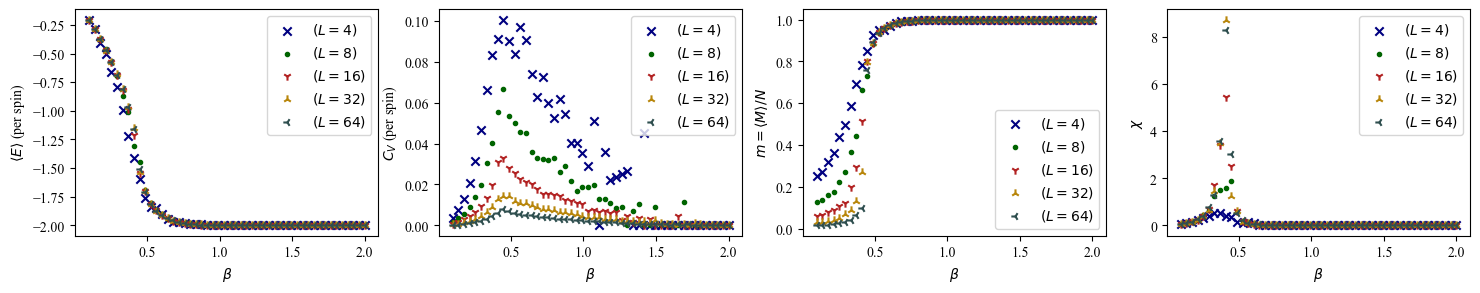

Critical Temperature, T_c = 2.227272727272727
CPU times: total: 52.6 s
Wall time: 1min 34s


In [12]:
%%time

T_c = comparingLattices()
print("Critical Temperature, T_c =", T_c)

Observations indicate that at lower temperatures, the energy per spin appears insensitive to changes in lattice size. Similarly, the magnetization does not exhibit notable dependency on lattice size at lower temperatures. This trend persists after reaching a threshold around $\beta = 0.45$ or $T \approx 2.22$, where the lattice size seemingly becomes inconsequential. Notably broad peaks are observed in the specific heat capacity ($C_V$) and susceptibility ($\chi$).
    
For lower temperatures, the influence of lattice size remains negligible. However, as temperatures rise, a discernible peak emerges in both $C_V$ and $\chi$, showing a decrease in magnitude as the lattice size increases. As the system approaches an infinite lattice ($N \rightarrow \infty$), the specific heat capacity ($C_V$) is anticipated to show a flattening behavior, essentially becoming a constant even at higher temperatures.
    
Beyond $\beta = 0.45$ or $T = 2.22$, intriguing behavior is witnessed in the plots of $\langle E \rangle$ (average energy) and $\chi$, as both exhibit a tendency to stabilize and remain nearly constant over varying $\beta$ and $L$.

From the plot, it is also clear that $\langle M \rangle \neq 0$ for low temperatures but $\langle M \rangle \approx 0$ for high temperatures and bigger lattice sizes. 

The Critical Temperature is expected to be $2.269$ for an infinite lattice (for $J=1$) but even for a very small finite lattice, the value of $T_c$ is very close to this expected value, showing less than $2\%$ deviation.

In the case of every graph, intriguing behaviour is noticed when $T=2.22$ which is also the critical temperature of the system. The phase transition is clear in every graph. 

In [47]:
@njit
def pbc_distance(rij, L):
    '''
    Gets the correct distance between two particles, accounting for periodic boundary conditions.
    
    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.
    • L : The size of the box.
    
    Returns:
    --------
    The function returns one value:
    • rij : The corrected r_ij, including the effects of periodic boundary conditions.
    '''
    for i in range(2):
        if np.abs(rij[i]) > 0.5 * L:
            rij[i] -= np.sign(rij[i]) * L
    return rij

@njit
def update_correlation(nr, Cr, r_bins, spins, L, x, y, i, j):
    '''
    Updates the correlation arrays based on spin interactions at specific locations.

    Parameters:
    -----------
    • nr : Array storing the number of spins in each distance bin.
    • Cr : Array storing correlation values.
    • r_bins : Array defining the bins for correlation values.
    • spins : Array representing the spin configuration.
    • L : Size of the box.
    • x, y : Coordinates of the first spin.
    • i, j : Coordinates of the second spin.
    '''
    if (i, j) != (x, y):
        rij = np.empty(2)
        rij[0] = i - x
        rij[1] = j - y
        for k in range(2):
            if np.abs(rij[k]) > 0.5 * L:
                rij[k] -= np.sign(rij[k]) * L
        r = np.sqrt(rij[0] ** 2 + rij[1] ** 2)  # Calculating distance r
        r_bin = np.searchsorted(r_bins, r)  # Finding corresponding r bin

        # Computing correlation
        correlation = spins[x, y] * spins[i, j]
        correlation -= (np.sum(spins) / (L * L)) ** 2  # Subtracting mean square

        # Updating nr and Cr arrays
        nr[r_bin] += 1
        Cr[r_bin] += correlation

#@njit
def get_correlation(spins):
    '''
    Calculates the correlation function for a given spin configuration.

    Parameters:
    -----------
    • spins : Array representing the spin configuration.

    Returns:
    --------
    • r_bins : Array defining the bins for correlation values.
    • Cr : Array representing the calculated correlation values.
    '''
    L = len(spins)

    # Defining r bins and arrays to store number of spins and correlations
    r_max = L / np.sqrt(2)  # Largest value of r
    r_bins = np.arange(1, r_max + 1)
    nr = np.zeros_like(r_bins)
    Cr = np.zeros_like(r_bins)

    # Loop over all spins
    for x in range(L):
        for y in range(L):
            for i in range(L):
                for j in range(L):
                    update_correlation(nr, Cr, r_bins, spins, L, x, y, i, j)

    # Computing the correlation function for this configuration
    Cr /= nr if np.any(nr != 0) else 1

    return r_bins, Cr

def exponential_decay(r, a, xi):
    '''
    Computes the exponential decay function.

    Parameters:
    -----------
    • r : Distance.
    • a : Exponential amplitude.
    • xi : Correlation length.

    Returns:
    --------
    • Exponential decay value at given distance, exponential amplitude, and correlation length.
    '''
    return a * np.exp(-r / xi)

def compute_correlation_length(temperatures, spins, steps=10_000):
    '''
    Computes correlation lengths for a range of temperatures.

    Parameters:
    -----------
    • temperatures : Array of temperatures to compute correlation lengths for.
    • spins : Array representing the spin configuration.
    • steps : Number of Monte Carlo steps (default: 10,000).

    Returns:
    --------
    • correlation_lengths : List of computed correlation lengths for each temperature.
    '''
    correlation_lengths = []

    for temp in tqdm(temperatures):
        final_config = spins.copy()
        energy = 0

        for _ in range(steps):
            energy, final_config = oneMCS(energy=energy, beta=1/temp, h=0, spins=final_config)
        
        r_values, Cr = get_correlation(final_config)
        popt, pcov = curve_fit(exponential_decay, r_values, Cr, maxfev=1000)
        a, xi = popt  # Extracting optimized parameters a and xi
        correlation_lengths.append(xi)

    return correlation_lengths


def display(temperatures, spins, steps=10_000):
    '''
    Displays final configurations and correlation functions for different temperatures.

    Parameters:
    -----------
    • temperatures : Array of temperatures for which to display configurations and functions.
    • spins : Array representing the spin configuration.
    • steps : Number of Monte Carlo steps (default: 10,000).
    '''
    fig, axs = plt.subplots(len(temperatures), 2, figsize=(10, 5 * len(temperatures)))

    for idx, temp in enumerate(temperatures):
        final_config = spins.copy()                               # Initializing with the initial spins configuration
        energy = 0

        # Performing Monte Carlo steps 
        for _ in tqdm(range(steps), desc=f'Temperature {temp:.4f}'):
            energy, final_config = oneMCS(energy=energy, beta=1/temp, h=0, spins=final_config)
        
        axs[idx, 0].imshow(final_config, cmap=mcolors.ListedColormap(['tomato', 'royalblue']), interpolation='nearest')
        axs[idx, 0].set_title(f"Final Configuration at T = {temp:.4f}")

        r_values, Cr = get_correlation(final_config)
        axs[idx, 1].plot(r_values, Cr, color='navy', marker='o', linestyle='-')
        axs[idx, 1].set_title(f"Correlation Function at T = {temp:.4f}")
        axs[idx, 1].set_xlabel("Distance (r)")
        axs[idx, 1].set_ylabel("Correlation (c(r))")
        axs[idx, 1].grid(True)

    plt.tight_layout()
    plt.show()

Temperature 6.6818: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9751.89it/s]


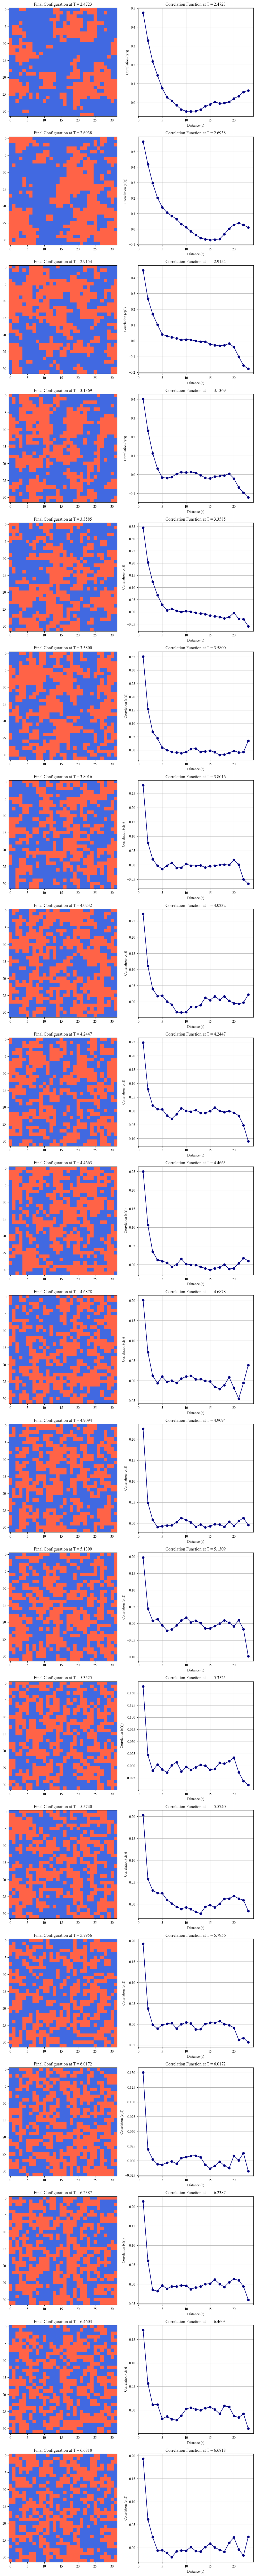

In [48]:
#temperatures = np.concatenate([[T_c], np.linspace(1.01 * T_c, 3 * T_c, 9)])  # Range of temperatures
temperatures = np.linspace(1.11*T_c, 3 * T_c, 20)
L = 32
spin_values = [1, -1]
initial_spins = 2*np.random.randint(0,2,size=(L,L)) - 1

display(temperatures, initial_spins)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.06s/it]


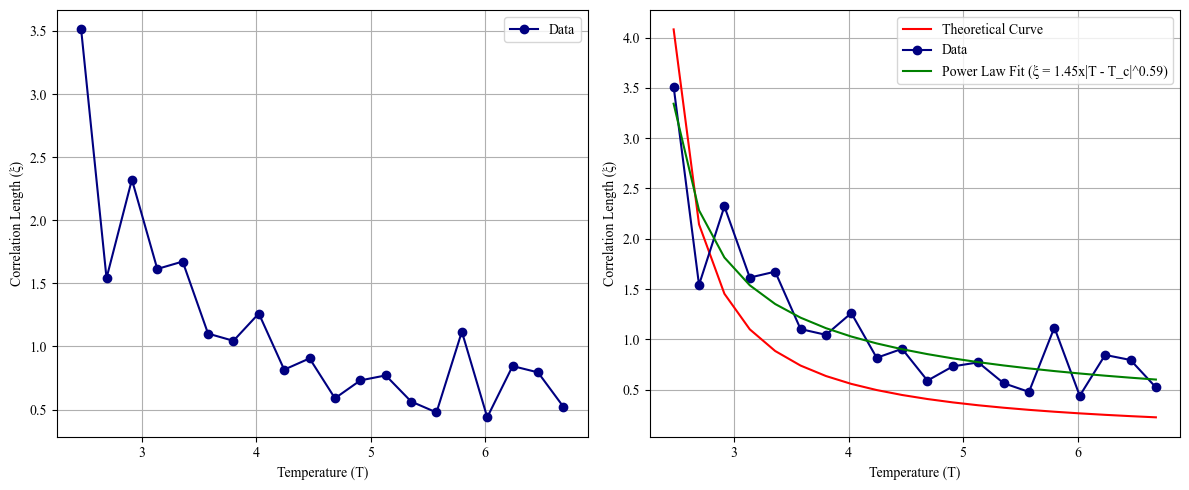

In [52]:
correlation_lengths = compute_correlation_length(temperatures, initial_spins)

def power_law(T, k, nu):
    return k * np.abs(T - T_c) ** (-nu) 

popt, pcov = curve_fit(power_law, temperatures, correlation_lengths)
k, nu = popt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the original data
axs[0].plot(temperatures, correlation_lengths, color='navy', marker='o', label='Data')
axs[0].set_xlabel("Temperature (T)")
axs[0].set_ylabel("Correlation Length (ξ)")
axs[0].legend()
axs[0].grid(True)

# Plotting the original data and the fitted curve for power law
axs[1].plot(temperatures, xi, color='red', label='Theoretical Curve')
axs[1].plot(temperatures, correlation_lengths, color='navy', marker='o', label='Data')
axs[1].plot(temperatures, power_law(temperatures, k, nu), color='green', label=f'Power Law Fit (ξ = {k:.2f}x|T - T_c|^{nu:.2f})')
axs[1].set_xlabel("Temperature (T)")
axs[1].set_ylabel("Correlation Length (ξ)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

At low temperatures, close to $T_c$, there is some hint of domain formation in the lattice but as the temperature increases, the spins become distributed and any hint of domains is lost. The correlation function falls as the distance increases. 

I tried running the simulation for temperatures below the critical temperature so that i can find the corresponding correlation length and its behaviour around $T_c$ but the correlation function for $T<T_c$ does not go as $c(r) \sim e^{-r/\xi}$ and fitting becomes as issue so for the correlation length, it is better to take temperatures above $T_c$ and try to infer from that what happens at $T_c$.

The graph of correlation length vs. temperature shows a power law dependence. To verify this, I fitted a power law curve and tried to obtain the value of the exponent. A Google search infromed me that the exponent should be $1$ [$\xi \sim |T - T_c |^{-1}$] but the value I am getting is close to half of it. Looking at the plots it seems that it differs by some constant but it is clear that it follows a power law dependence. 

As a phase transition takes place at $T=T_c$, the correlation length should diverge at $T=T_c$ or the graph should peak at that point and fall for both lower and higher temperatures.